In [57]:
import geopandas as gpd
from shapely.geometry import box

In [58]:
gdf = gpd.read_file("./resources/FAO_fishing_areas/FAO_AREAS_ERASE_LOWRES.json")
print(gdf.crs)

EPSG:4326


[-69.6095 -60.     -50.     -32.4483]


<Axes: >

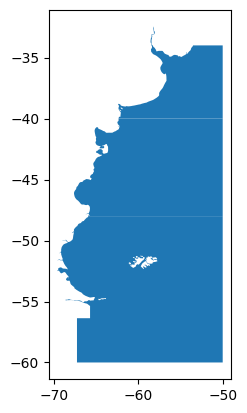

In [59]:
FAO_41 = gdf[gdf['F_AREA'] == '41']
FAO_41_Sub_32_31_23 = FAO_41[FAO_41['F_DIVISION'].isin(['41.3.2', '41.3.1', '41.2.3'])]
print(FAO_41_Sub_32_31_23.total_bounds)
FAO_41_Sub_32_31_23.plot()


EPSG:4326


,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,8389,Overlapping claim Falkland / Malvinas Islands:...,8623,Overlapping claim,2208,Falkland / Malvinas Islands,FLK,United Kingdom,8623.0,2149.0,...,GBR,ARG,None,826,32.0,NaN,238,238.0,NaN,"POLYGON ((-61.62049 -53.78199, -61.67169 -53.7..."
4,8466,Argentinian Exclusive Economic Zone,2149,200NM,2149,Argentina,ARG,Argentina,NaN,NaN,...,ARG,None,None,32,NaN,NaN,32,NaN,NaN,"POLYGON ((-58.20066 -32.44837, -58.20066 -32.4..."
1,8465,Chilean Exclusive Economic Zone,2165,200NM,2165,Chile,CHL,Chile,NaN,NaN,...,CHL,None,None,152,NaN,NaN,152,NaN,NaN,"MULTIPOLYGON (((-69.60937 -54.78627, -69.60937..."
2,48961,Joint regime area: Uruguay / Argentina,2216,Joint regime,2216,Uruguay,URY,Uruguay,2149.0,2149.0,...,URY,ARG,None,858,32.0,NaN,858,32.0,NaN,"POLYGON ((-54.95056 -34.97392, -54.94997 -34.9..."
3,8467,Uruguayan Exclusive Economic Zone,2216,200NM,2216,Uruguay,URY,Uruguay,NaN,NaN,...,URY,None,None,858,NaN,NaN,858,NaN,NaN,"POLYGON ((-58.19277 -32.45385, -58.19561 -32.4..."
5,8464,Brazilian Exclusive Economic Zone,2143,200NM,2143,Brazil,BRA,Brazil,NaN,NaN,...,BRA,None,None,76,NaN,NaN,76,NaN,NaN,"POLYGON ((-50.00118 -35.71032, -50.00228 -35.7..."


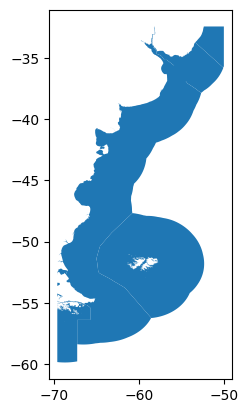

In [ ]:
min_lon, min_lat, max_lon, max_lat = FAO_41_Sub_32_31_23.total_bounds
bbox = (min_lon, min_lat, max_lon, max_lat)
eez = gpd.read_file("./resources/Marine_Regions/World_EEZ_v12/eez_v12.shp", bbox=bbox)
print(eez.crs)
bbox_geom = box(*bbox)
eez_clipped = gpd.clip(eez, bbox_geom)
eez_clipped.plot()


<Axes: >

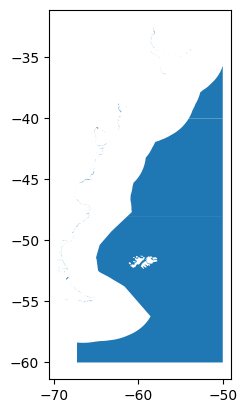

In [ ]:
eez_falk = eez_clipped[eez_clipped['GEONAME'] == "Overlapping claim Falkland / Malvinas Islands: United Kingdom / Argentina"]
eez_no_falk = eez_clipped[eez_clipped['GEONAME'] != "Overlapping claim Falkland / Malvinas Islands: United Kingdom / Argentina"].copy()
fao_minus_eez = gpd.overlay(FAO_41_Sub_32_31_23, eez_no_falk, how='difference')

In [62]:
land_polygons = gpd.read_file("./resources/OpenStreet_features/land-polygons-complete-4326/land_polygons.shp", bbox=bbox)
land_clipped = gpd.clip(land_polygons, bbox_geom)

In [ ]:
buffer_m = 12 * 1852 #12 millas nauticas, no queremos aguas territoriales
land_buffer = (land_clipped
               .to_crs(epsg=3857)            # metric for buffering
               .geometry
               .buffer(buffer_m))            # buffer in meters

land_buffer_gdf = gpd.GeoDataFrame(geometry=land_buffer, crs="EPSG:3857").to_crs(epsg=4326) #le aplicamos el buffer y lo conertimos de nuevo a WGS84

In [ ]:

available_fishing_area = gpd.overlay(fao_minus_eez, land_buffer_gdf, how='difference') #area disponible para pesca internacional

<Axes: >

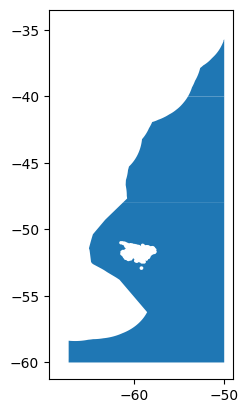

In [65]:
available_fishing_area.plot()